<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/customnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Neural Net

In [1]:
from numpy import loadtxt
import numpy as np
import os
import shutil
import math
import zipfile
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

import sklearn 
from sklearn import metrics
import tensorflow_addons as tfa

#Unzip Dataset

In [3]:
dataset_name = 'dataset_binary'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

#Create Dataloader

In [4]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (96, 96)
COLOR_MODE = 'grayscale'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 33915 files belonging to 2 classes.
Found 5339 files belonging to 2 classes.
Found 2819 files belonging to 2 classes.


In [5]:
def show_example(train_dataset):
  for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = np.asarray(image[0]).squeeze()
    print(first_image.shape)
    # for i in range(9):
    #   ax = plt.subplot(3, 3, i + 1)
      # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      # plt.imshow(augmented_image[0] / 255)
    # print(image)
    plt.gray()
    plt.imshow(first_image / 255, plt.get_cmap('gray'))
    plt.axis('off')
    
    break 

# Run with this line:
# show_example(train_dataset)

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# GPU Setup

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Create Model

In [9]:
num_classes = 2

last_layer = Dense(2, activation='softmax') if num_classes == 2 else Dense(3, activation='softmax')

In [19]:

model_cnn = keras.Sequential(
    [
        keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 1)),  # 96x96 greyscale image
        layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation="relu"),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation="relu"),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation="relu"),        # layers.MaxPool2D(),
        layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Flatten(name='flatten'),
        Dense(100, activation='relu'),
        Dense(100, activation='relu'),
        Dense(64, activation='relu'),
        last_layer  
    ]
)

In [20]:
model_full = keras.Sequential(
    [
        keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 1)),  # 96x96 greyscale image
        layers.Flatten(name='flatten'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        last_layer
    ]
)

In [21]:
model = model_full
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                589888    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 128)              

In [22]:
def f1_score(num_classes):
  return tfa.metrics.F1Score(num_classes=num_classes, average="weighted")

In [23]:
# Compile model with accuracy and weighted F1 Score
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score(num_classes)])

In [24]:
# Configure eary stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initial Model Training

## Initial results without training

In [25]:
loss0, accuracy0, f1_score0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1_score0))

167/167 [==============================] - 2s 14ms/step - loss: 1.7005 - accuracy: 0.5001 - f1_score: 0.3334
initial loss: 1.70
initial accuracy: 0.50
initial f1_score: 0.33


## Fit (Initial)

In [26]:
initial_epochs = 20

In [28]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                  epochs=initial_epochs,
                  validation_data=dev_dataset,
                  callbacks=[callback])
  # model.fit(train_it, epochs=20, batch_size=batchX.shape[0], validation_data=dev_it, validation_batch_size=batchX.shape[0])

Epoch 1/20
1060/1060 [==============================] - 20s 19ms/step - loss: 0.5319 - accuracy: 0.7602 - f1_score: 0.7533 - val_loss: 0.5103 - val_accuracy: 0.7601 - val_f1_score: 0.7601
Epoch 2/20
1060/1060 [==============================] - 19s 18ms/step - loss: 0.4789 - accuracy: 0.7870 - f1_score: 0.7804 - val_loss: 0.5165 - val_accuracy: 0.7488 - val_f1_score: 0.7485
Epoch 3/20
1060/1060 [==============================] - 19s 18ms/step - loss: 0.4668 - accuracy: 0.7912 - f1_score: 0.7855 - val_loss: 0.5023 - val_accuracy: 0.7647 - val_f1_score: 0.7633
Epoch 4/20
1060/1060 [==============================] - 19s 18ms/step - loss: 0.4526 - accuracy: 0.7980 - f1_score: 0.7931 - val_loss: 0.4752 - val_accuracy: 0.7767 - val_f1_score: 0.7757
Epoch 5/20
1060/1060 [==============================] - 19s 18ms/step - loss: 0.4117 - accuracy: 0.8198 - f1_score: 0.8175 - val_loss: 0.4236 - val_accuracy: 0.8144 - val_f1_score: 0.8144
Epoch 6/20
1060/1060 [==============================] - 18s 

In [89]:
binary = True
if binary:
  model.save('/content/binary_model')

save_to_drive=False
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model')

INFO:tensorflow:Assets written to: /content/binary_model/assets


In [54]:
# binary_model.get_weights()

## Learning Plot

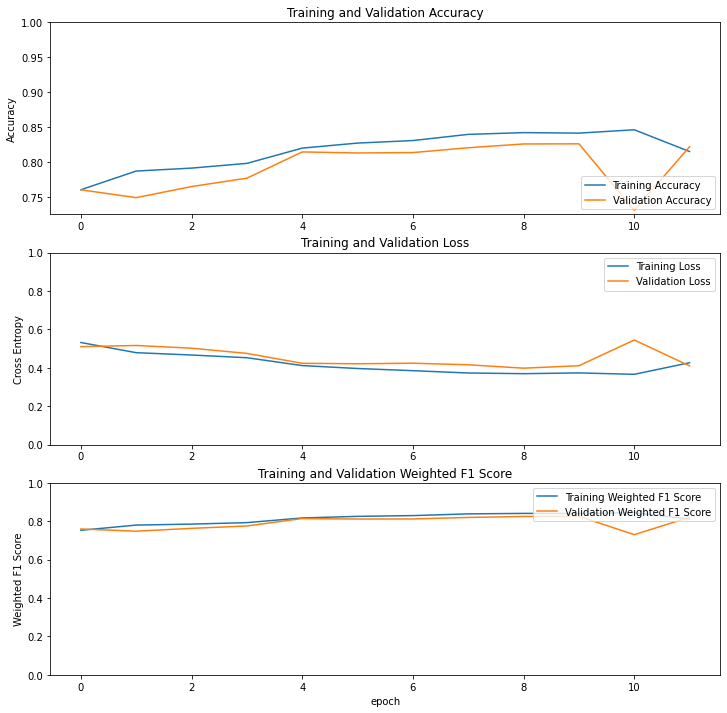

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(f1_score, label='Training Weighted F1 Score')
plt.plot(val_f1_score, label='Validation Weighted F1 Score')
plt.legend(loc='upper right')
plt.ylabel('Weighted F1 Score')
plt.ylim([0,1.0])
plt.title('Training and Validation Weighted F1 Score')
plt.xlabel('epoch')
plt.show()

# Rounded Weights Evaluation

In [81]:
def modify_weights(weights, transform):
  new_weights = []
  for layer_num, layer_weights in enumerate(weights):
    if layer_num < len(weights):
      new_weights.append(transform(layer_weights))
      # print(f"=============== Layer {layer_num} ===============\n")
      # print(layer_weights)
      # print(new_weights[layer_num])
      # print('\n')
  return new_weights


def round2(layer_weights):
  return np.round_(layer_weights, 2)

def round1(layer_weights):
  return np.round_(layer_weights, 1)

def round0(layer_weights):
  return np.round_(layer_weights)

def pow_2_scale(layer_weights):
  sign = binarise(layer_weights)
  pow_2 = sign*2**(-np.round_(np.log2(np.absolute(layer_weights))))
  return pow_2

def binarise(layer_weights):
  return 2*((layer_weights < 0) - 0.5)

transform = round1
# transform = pow_2_scale
# transform = binarise

weights = model.get_weights() # returs a numpy list of weights
new_weights = modify_weights(weights, transform)
print(new_weights)

[array([[ 0. , -0. ,  0. , ..., -0. , -0. , -0. ],
       [-0. ,  0. , -0. , ..., -0. , -0. ,  0. ],
       [ 0. , -0. , -0. , ...,  0. , -0. , -0. ],
       ...,
       [-0.1,  0. ,  0. , ...,  0. ,  0. , -0. ],
       [-0.1,  0. ,  0. , ...,  0. ,  0. , -0. ],
       [-0.1, -0. , -0. , ...,  0. , -0. ,  0. ]], dtype=float32), array([ 0.2, -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,
       -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0. , -0. ,
       -0. , -0. , -0. , -0. , -0. , -0.2, -0. , -0. , -0. , -0. , -0. ,
        0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0.2,
       -0. , -0. , -0. , -0. , -0. , -0. , -0.1, -0. , -0. , -0. , -0. ,
       -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ],
      dtype=float32), array([[-0.1,  0.1, -0. , ..., -0.1, -0.1, -0. ],
       [-0.1,  0.2, -0.1, ..., -0.1,  0.2,  0.2],
       [ 0. , -0.2,  0.1, ...,  0.1,  0.1, -0.2],
       ...,
       [ 0.2, -0.2, -0.2, ...,  0. ,  0.2, -0.2],
       [-

In [82]:
binarised_test_model = keras.models.load_model('/content/binary_model', custom_objects={'F1Score': tfa.metrics.F1Score})

In [83]:
binarised_test_model.set_weights(new_weights)

In [84]:
_, accuracy, f1_score = binarised_test_model.evaluate(dev_dataset)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy, f1_score = model.evaluate(dev_dataset)
print('Accuracy: %.2f' % (accuracy*100))



167/167 [==============================] - 2s 15ms/step - loss: 0.4414 - accuracy: 0.8050 - f1_score: 0.8021
Accuracy: 80.50
167/167 [==============================] - 2s 15ms/step - loss: 0.4100 - accuracy: 0.8219 - f1_score: 0.8210
Accuracy: 82.19


# Evaluate on Test Set
(COMMENTED until development finished)

In [85]:
# _, accuracy = model.evaluate(dev_it)
# print('Accuracy: %.2f' % (accuracy*100))

# Convert tf model to tflite

In [ ]:
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)